# Star type classification - NASA dataset

## Imports

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import plotly.express as px
import plotly
import math
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

## Data loading and exploration

In [2]:
df = pd.read_csv("Stars.csv")

In [3]:
df.shape

(240, 7)

-Small data set, only 240 entries

-7 variables

In [4]:
df.columns

Index(['Temperature', 'L', 'R', 'A_M', 'Color', 'Spectral_Class', 'Type'], dtype='object')

In [5]:
df.head(-10)

,Temperature,L,R,A_M,Color,Spectral_Class,Type
0,3068,0.002400,0.1700,16.120,Red,M,0
1,3042,0.000500,0.1542,16.600,Red,M,0
2,2600,0.000300,0.1020,18.700,Red,M,0
3,2800,0.000200,0.1600,16.650,Red,M,0
4,1939,0.000138,0.1030,20.060,Red,M,0
...,...,...,...,...,...,...,...
225,18734,224780.000000,46.0000,-7.450,Blue,O,4
226,9892,593900.000000,80.0000,-7.262,Blue,O,4
227,10930,783930.000000,25.0000,-6.224,Blue,O,4
228,23095,347820.000000,86.0000,-5.905,Blue,O,4


### Check for null-values and check types

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Temperature     240 non-null    int64  
 1   L               240 non-null    float64
 2   R               240 non-null    float64
 3   A_M             240 non-null    float64
 4   Color           240 non-null    object 
 5   Spectral_Class  240 non-null    object 
 6   Type            240 non-null    int64  
dtypes: float64(3), int64(2), object(2)
memory usage: 13.2+ KB


-No null values

-4 numerical variables

-2 categorical

-numerical target 

## Explore variables

### Explore target variable

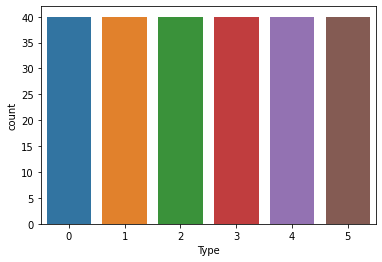

In [7]:
sns.countplot(x="Type", data=df)
plt.show()

-There is an equal number of each star Type observations. This is great

### Explore numerical variables

In [8]:
df_vars_num = df.loc[:, ["Temperature", "L", "R", "A_M"]]
df_vars_num.describe()

,Temperature,L,R,A_M
count,240.000000,240.000000,240.000000,240.000000
mean,10497.462500,107188.361635,237.157781,4.382396
std,9552.425037,179432.244940,517.155763,10.532512
min,1939.000000,0.000080,0.008400,-11.920000
25%,3344.250000,0.000865,0.102750,-6.232500
50%,5776.000000,0.070500,0.762500,8.313000
75%,15055.500000,198050.000000,42.750000,13.697500
max,40000.000000,849420.000000,1948.500000,20.060000


### Check boxplots of each variable

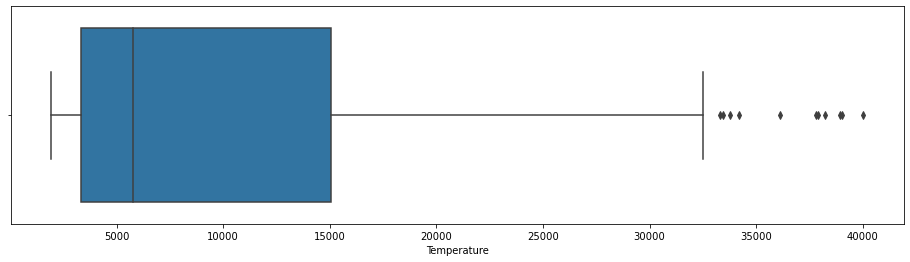

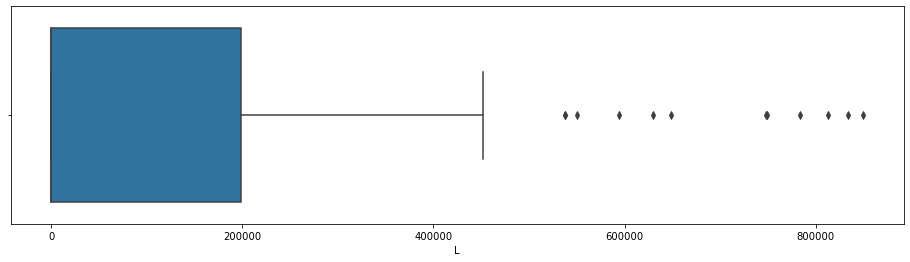

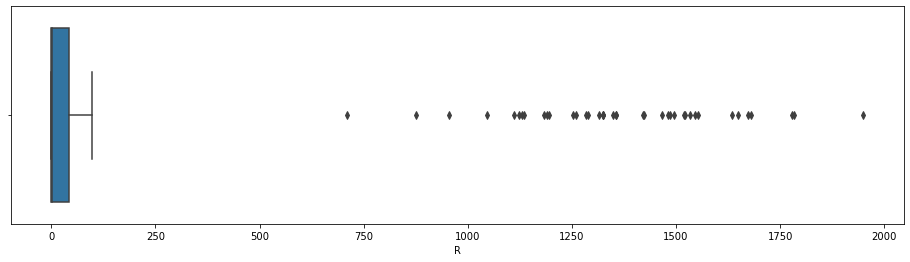

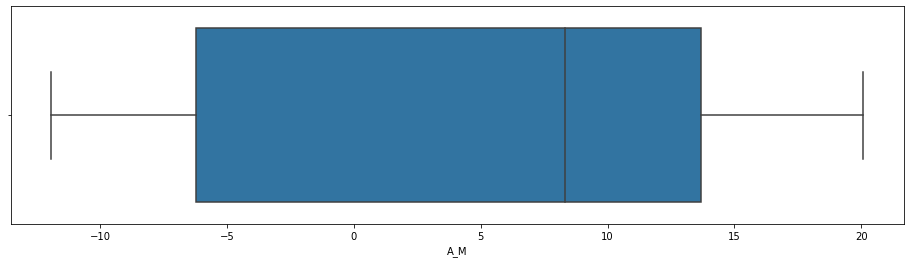

In [9]:
for col_name in df_vars_num:
    plt.figure(figsize=(16, 4))
    sns.boxplot(x=df_vars_num[col_name])
    plt.show()

-Temperature, L, R variables contain outliers

### Check distplots of each numerical variable

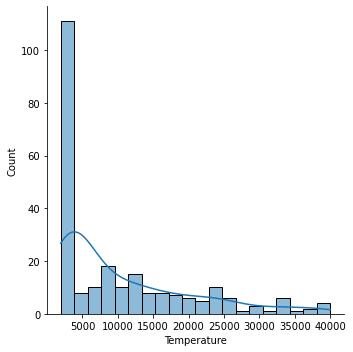

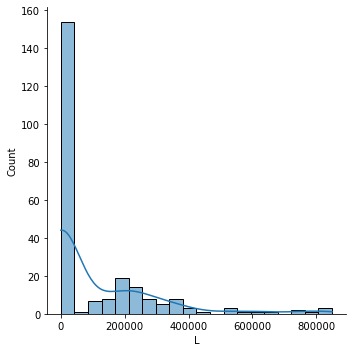

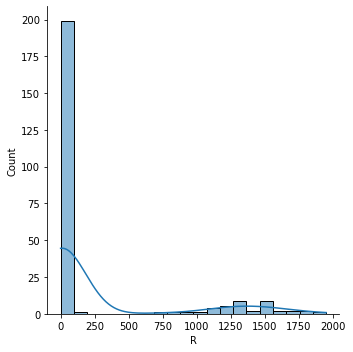

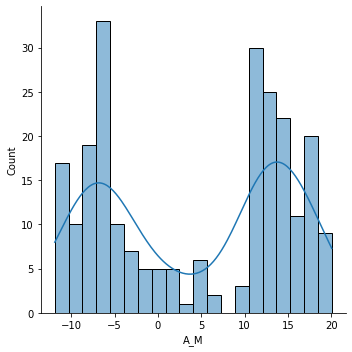

In [10]:
for col_name in df_vars_num:

    sns.displot(x=col_name, kde=True, bins=20, data=df_vars_num)
    plt.show()

-All variables don't follow the normal distribution

### Check boxplots of numerical values per target variable 

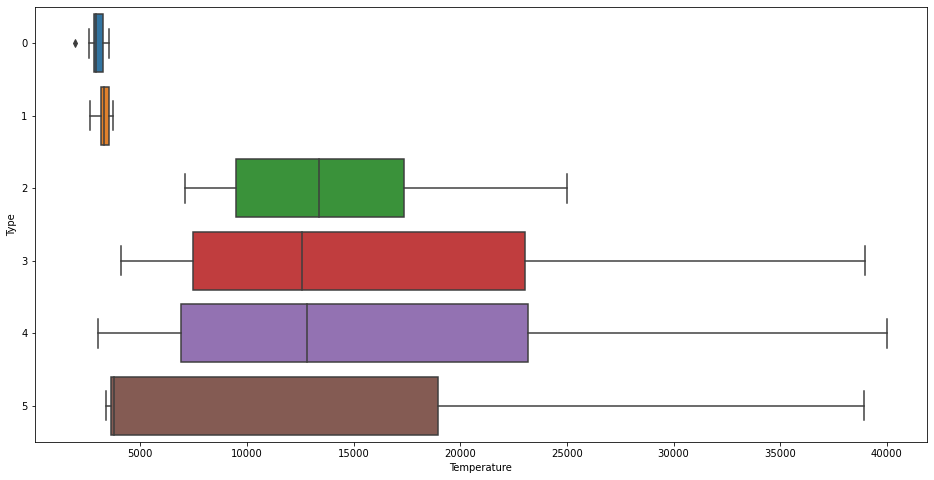

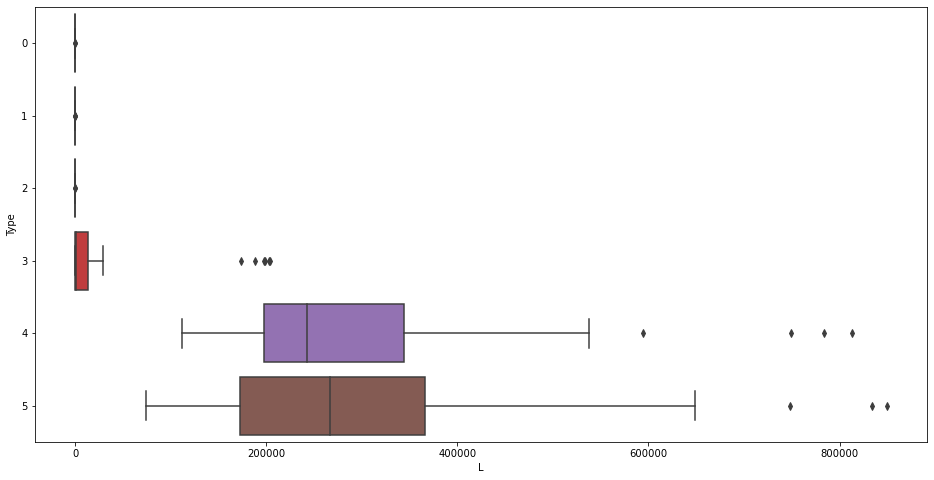

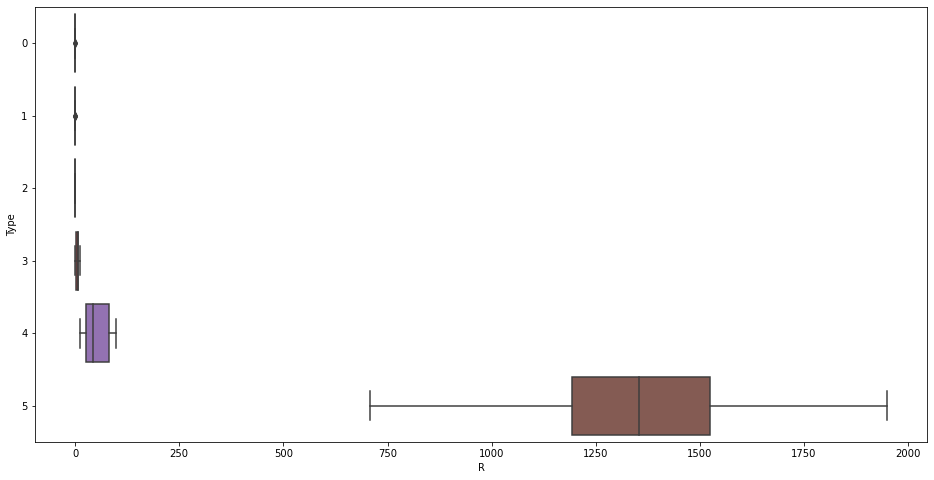

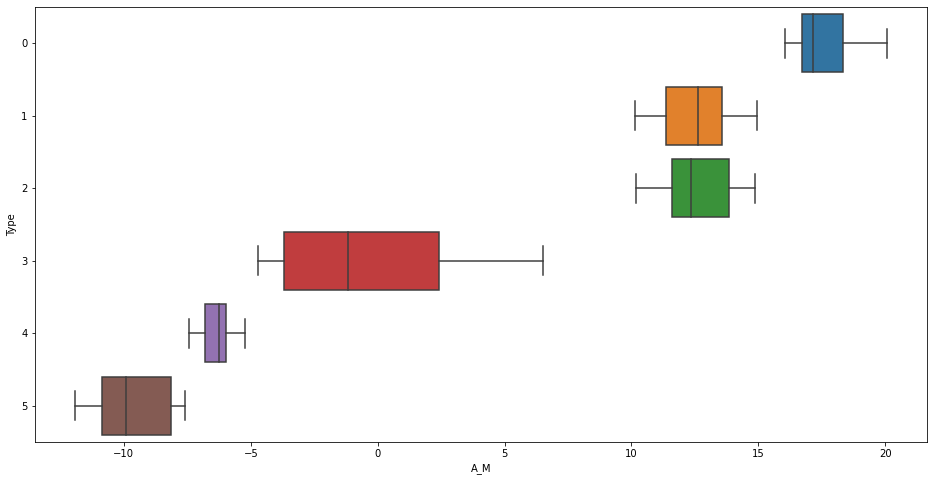

In [11]:
for col_name in df_vars_num:
    plt.figure(figsize=(16, 8))
    sns.boxplot(y="Type", x=col_name, data=df, orient="h")
    plt.show()

-All numerical variables strongly affect star type

-Stars of Type 0 and 1 always have Temperature below 5000

-Types 0-2 have much lower Luminosity than Types 4-5. Majority of Type 3 stars also has much lower Luminosity (there are outliers)

-Stars of Type 5 have much  larger radius than other types

-Absolute Magnintude (A_M) seems to get lower for stars of higher Type

### Explore categorical variables

In [12]:
df_vars_cat = df.loc[:, ["Color", "Spectral_Class"]]
df_vars_cat.describe()

,Color,Spectral_Class
count,240,240
unique,17,7
top,Red,M
freq,112,111


### Check unique categorical values for "Color"

In [13]:
df["Color"].unique()

array(['Red', 'Blue White', 'White', 'Yellowish White', 'Blue white',
       'Pale yellow orange', 'Blue', 'Blue-white', 'Whitish',
       'yellow-white', 'Orange', 'White-Yellow', 'white', 'yellowish',
       'Yellowish', 'Orange-Red', 'Blue-White'], dtype=object)

- Right away we can notice that there's several values that are almost exactly the same, namely:

    - "yellowish", "Yellowish", "Yellow"
    
    - "Blue White", "Blue white", "Blue-white", "Blue-White"
    
    - "yellow-white" and "White-Yellow", although it's possible that there's a difference in dominant colour in these cases. 
    
    - "white", "White", "Whitish" , although it's possible that they actually correspond to a slightly different colour.
    
- The first 2 cases can be safely assumed to correspond to the same actual colour type.

- The other 2 cases are suspected to also correspond to the same colour, but we should check temperature distributions of each pair and check if they overlap, just to be safe.

- As colours of the stars are strongly correlated with their temperatures, we can transform this categorical variable to a sequential variable described by a scale of numbers, where the lowest number is assigned to the stars with the coldest colour (Red) and the highest to stars with the hottest colour (Blue)


- Right away we can notice that there's several values that are almost exactly the same, namely:

    - "yellowish", "Yellowish", "Yellow"
    
    - "Blue White", "Blue white", "Blue-white", "Blue-White"
    
    - "yellow-white" and "White-Yellow"
    
    - "white", "White", "Whitish"
    
- We can remap those similar values

![Star Colours](https://i.stack.imgur.com/XyJyp.jpg)

- As can be observed on the above image, colours of the stars are strongly correlated with their temperatures. Because of this, we can transform this categorical variable using Label Encoding, so that stars with "colder" colours get lower values and stars with "hotter" colours get higher values.

- We will change the name of "Color" column to "Color_name" and use the name "Color" for the newly created label-encoded column instead.


### Re-map Color values

In [14]:
remap_dict = {
    'Red': 'Red',
    'Blue White': 'Blue-White',
    'White': 'White',
    'Yellowish White': 'White-Yellow',
    'Blue white': 'Blue-White',
    'Pale yellow orange': 'Yellow-Orange',
    'Blue': 'Blue',
    'Blue-white': 'Blue-White',
    'Whitish': 'White',
    'yellow-white': 'White-Yellow',
    'Orange': 'Orange',
    'White-Yellow': 'White-Yellow',
    'white': 'White',
    'yellowish': 'Yellow',
    'Yellowish': 'Yellow',
    'Orange-Red': 'Orange-Red',
    'Blue-White': 'Blue-White'
}

df["Color_name"] = df["Color"].map(remap_dict)
df["Color_name"].unique()

array(['Red', 'Blue-White', 'White', 'White-Yellow', 'Yellow-Orange',
       'Blue', 'Orange', 'Yellow', 'Orange-Red'], dtype=object)

### Check count of each color's occurence 

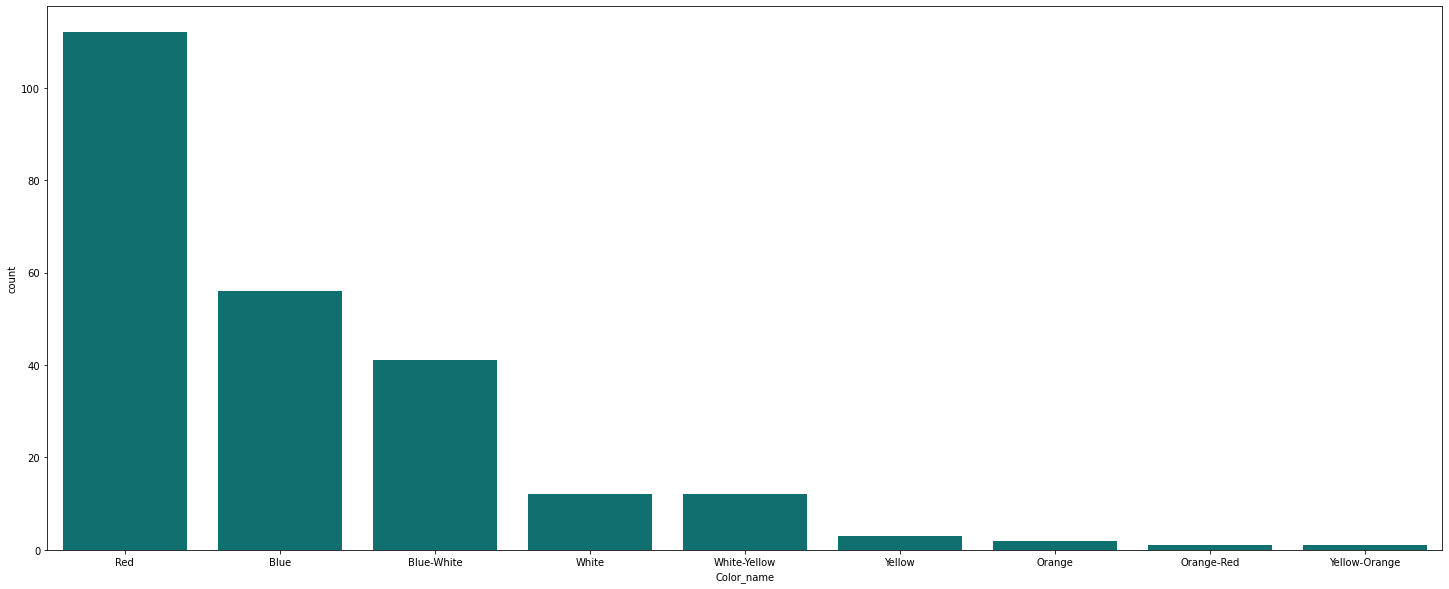

In [15]:
plt.figure(figsize=(25, 10))
sns.countplot(x="Color_name", data=df,
              order=df['Color_name'].value_counts().index, color="teal")
plt.show()

-Red is the most common colour, Orange-Red is the least common.

Next, we will use label encoding to assign a number to every colour type in range 0-8, with 0 being the "coldest"- Red, and 8 being the "hottest"- Blue

### Encode Color Variable

In [16]:
remap_dict_2 = {
    "Red": 0,
    "Orange-Red": 1,
    "Orange": 2,
    "Yellow-Orange": 3,
    "Yellow": 4,
    "White-Yellow": 5,
    "White": 6,
    "Blue-White": 7,
    "Blue": 8
}

df["Color"] = df["Color_name"].map(remap_dict_2)
df["Color"].unique()

array([0, 7, 6, 5, 3, 8, 2, 4, 1], dtype=int64)

### Check unique categorical values for "Spectral_Class"

In [17]:
df["Spectral_Class"].unique()

array(['M', 'B', 'A', 'F', 'O', 'K', 'G'], dtype=object)

-According to the Wikipedia article on Stellar classification (https://en.wikipedia.org/wiki/Stellar_classification):

        "Most stars are currently classified under the Morgan–Keenan (MK) system using the letters O, B, A, F, G, K, and M, a sequence from the hottest (O type) to the coolest (M type)."
        
With that knowledge in mind, we can Label-encode this variable in a similar fashion to how we dealt with "Color" variable.

### Check count of each Spectral_Classes' occurence 

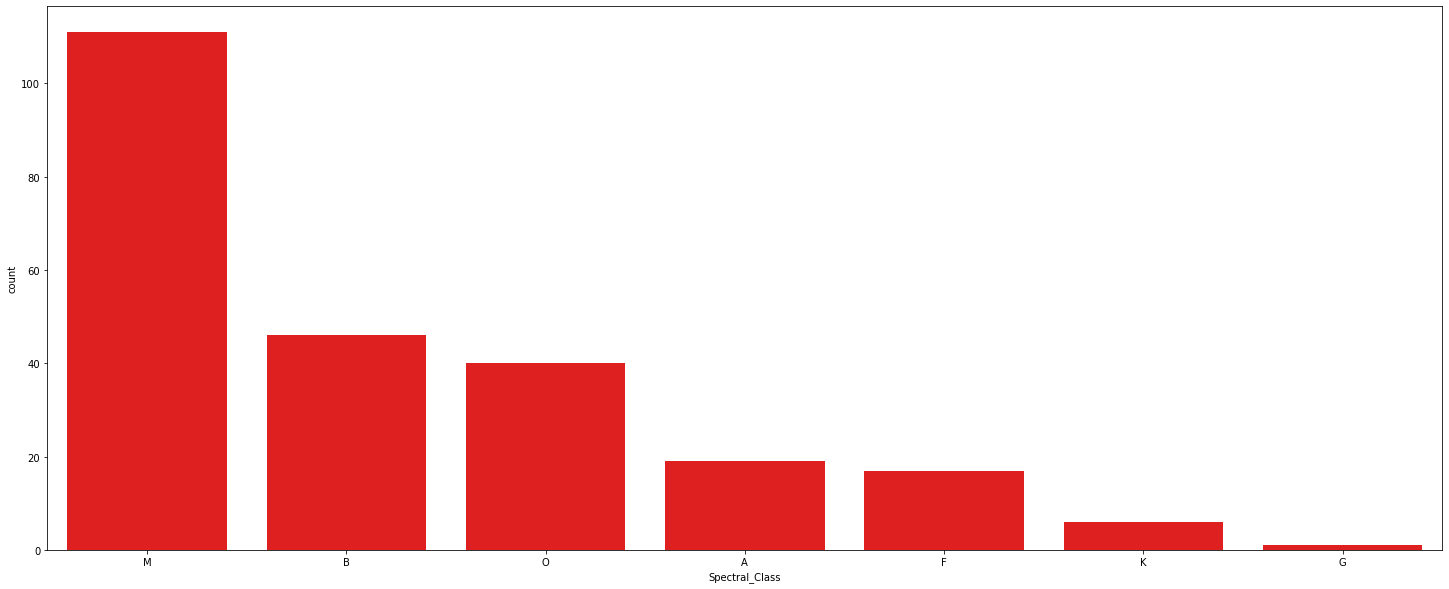

In [18]:
plt.figure(figsize=(25, 10))
sns.countplot(x="Spectral_Class", data=df,
              order=df['Spectral_Class'].value_counts().index, color="red")
plt.show()

-M is the most common spectral class and G is the least common.

Next, we will use label encoding to assign a number to every spectral class in range 0-6, with 0 being the "coldest"- M, and 6 being the "hottest"- O, just like with the "Color" variable.

### Encode Spectral_Class Variable

In [19]:
df["Spectral_Class_name"] = df["Spectral_Class"]

remap_dict_3 = {
    "M": 0,
    "K": 1,
    "G": 2,
    "F": 3,
    "A": 4,
    "B": 5,
    "O": 6
}

df["Spectral_Class"] = df["Spectral_Class_name"].map(remap_dict_3)
df["Spectral_Class"].unique()

array([0, 5, 4, 3, 6, 1, 2], dtype=int64)

### Check countplots of categorical values per target variable 

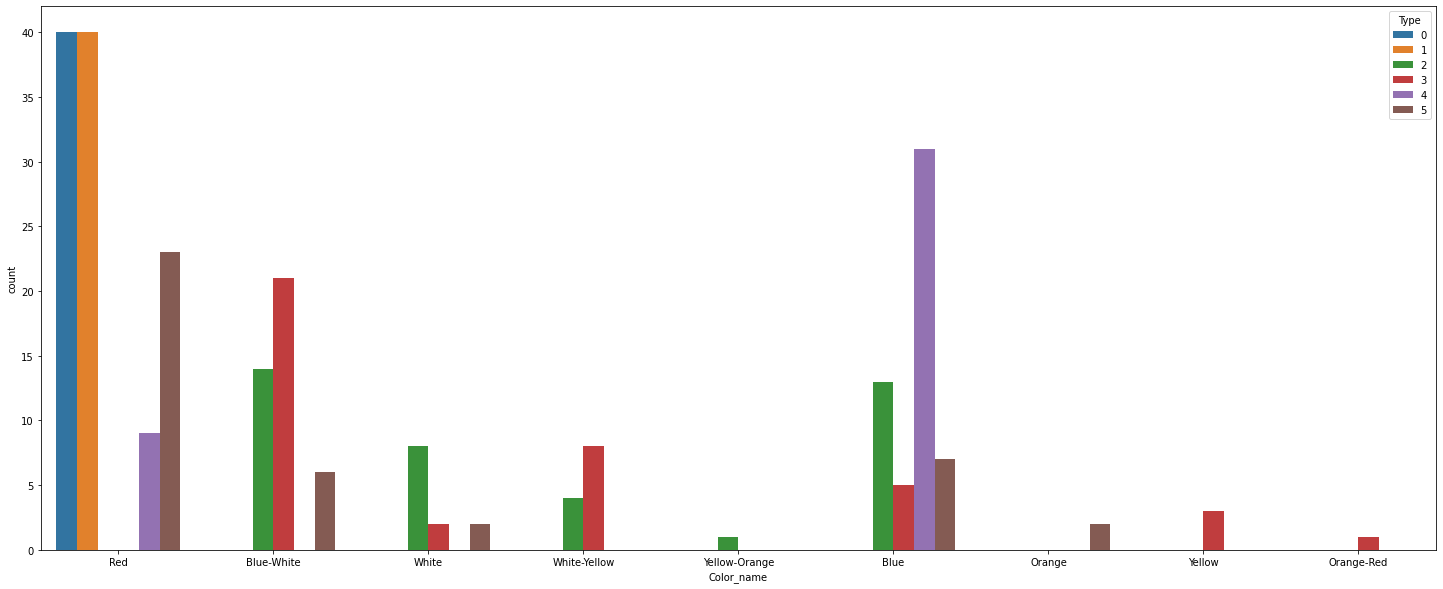

In [20]:
plt.figure(figsize=(25, 10))
sns.countplot(x="Color_name", hue="Type", data=df)
plt.show()

Observations:

- Type 0 and 1 stars are exclusively Red

- No Type 3 stars are Red

- All Yellow and Orange-Red stars are Type 3

- All Yellow-Orange stars are Type 2

- All Orange stars are Type 5

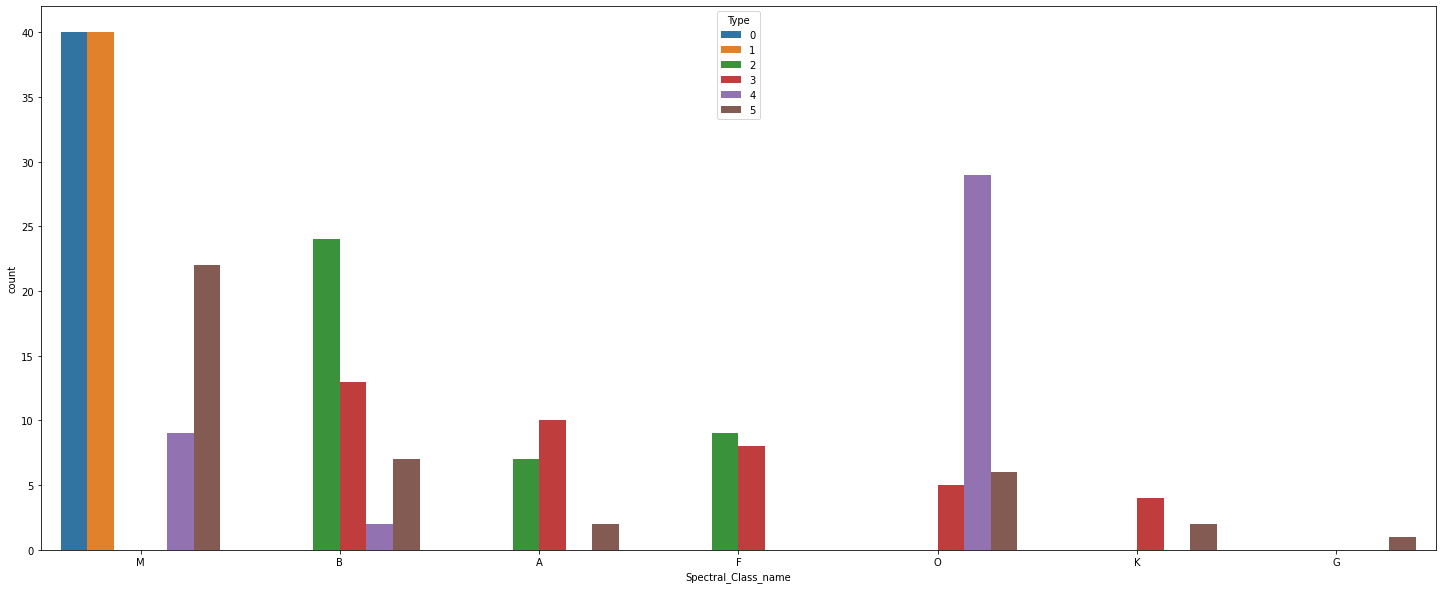

In [21]:
plt.figure(figsize=(25, 10))
sns.countplot(x="Spectral_Class_name", hue="Type", data=df)
plt.show()

Observations:

- Type 0 and 1 stars are exclusively Class M

- All Class G stars are Type 5

- Majority of Type 4 stars belong to class O

- Majority of Type 2 stars belong to class B

### Check heatmap for variable correlations

#### Pearson

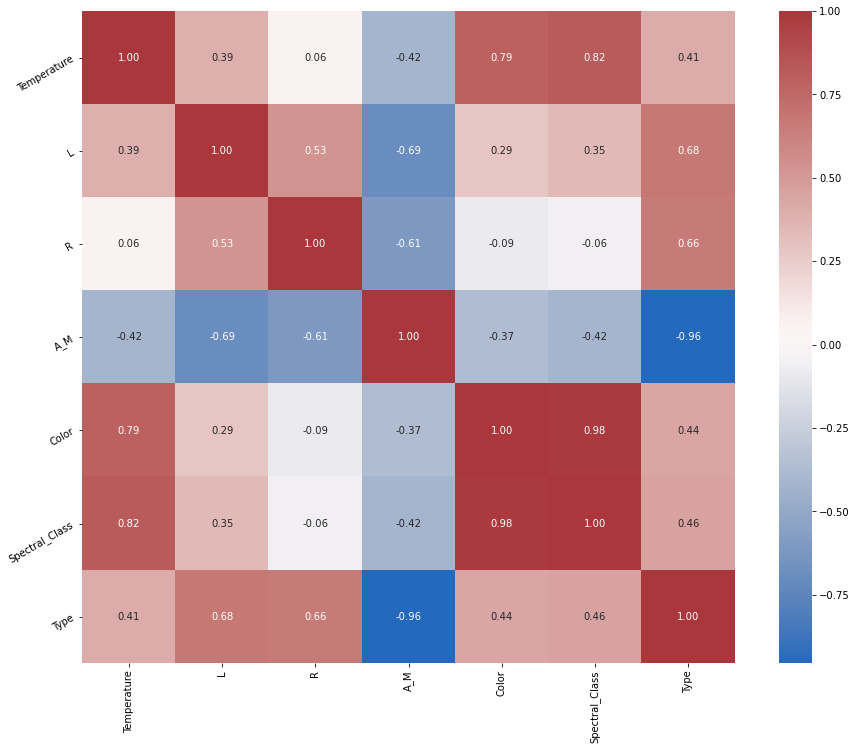

In [22]:
correlations = df.corr()
plt.figure(figsize=(16, 12))
ax = sns.heatmap(correlations, square=True, annot=True,
                 fmt='.2f', linecolor='white', cmap="vlag")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=10)
ax.set_yticklabels(ax.get_yticklabels(), rotation=30, fontsize=10)
plt.show()

-A_M and Type are very heavily negatively correlated

-A_M and L, R are also negatively correlated

-Type and L, R are positively correlated

-L and R are positively correlated

-Color and Temperature are heavily positively correlated

-Spectral_Class and Temperature are heavily positively correlated

-Spectral_Class and Color are very heavily positively correlated

TODO

#### Kendall

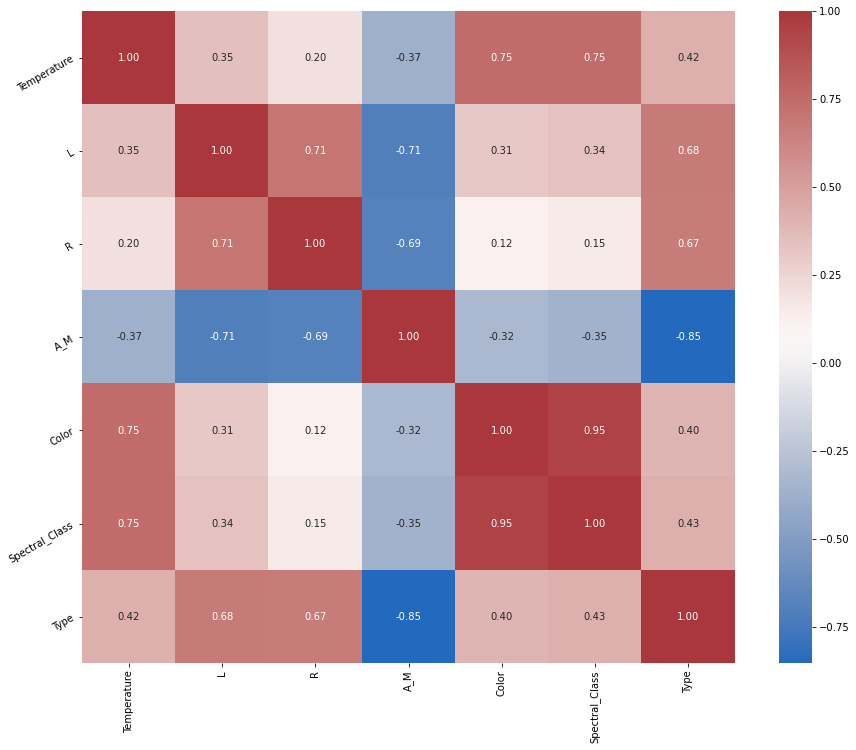

In [23]:
correlations = df.corr(method='kendall')
plt.figure(figsize=(16, 12))
ax = sns.heatmap(correlations, square=True, annot=True,
                 fmt='.2f', linecolor='white', cmap="vlag")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=10)
ax.set_yticklabels(ax.get_yticklabels(), rotation=30, fontsize=10)
plt.show()

#### Spearman

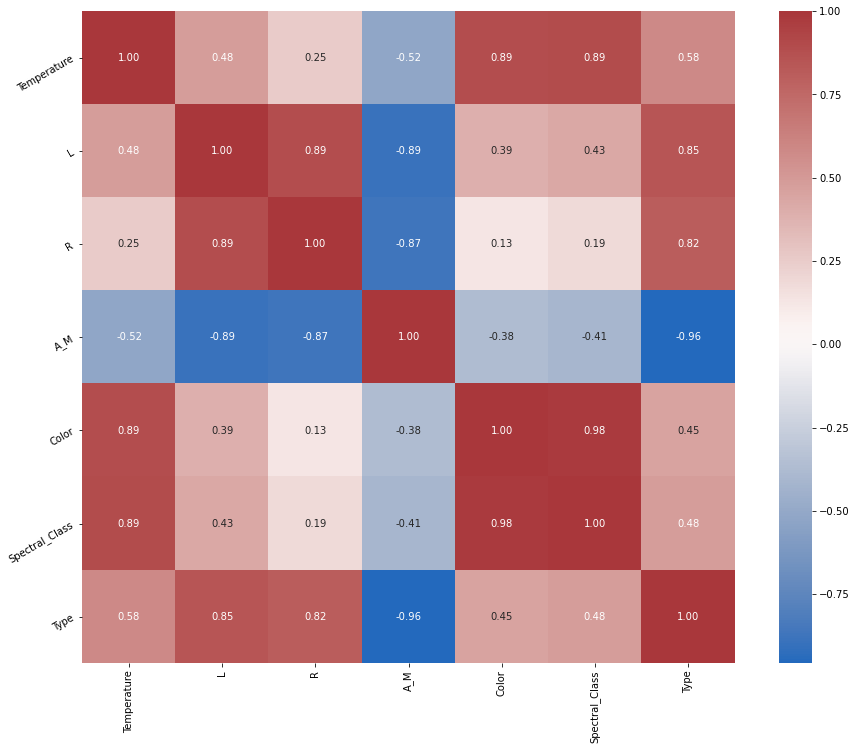

In [24]:
correlations = df.corr(method='spearman')
plt.figure(figsize=(16, 12))
ax = sns.heatmap(correlations, square=True, annot=True,
                 fmt='.2f', linecolor='white', cmap="vlag")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=10)
ax.set_yticklabels(ax.get_yticklabels(), rotation=30, fontsize=10)
plt.show()

### Check pairplot for variable correlations

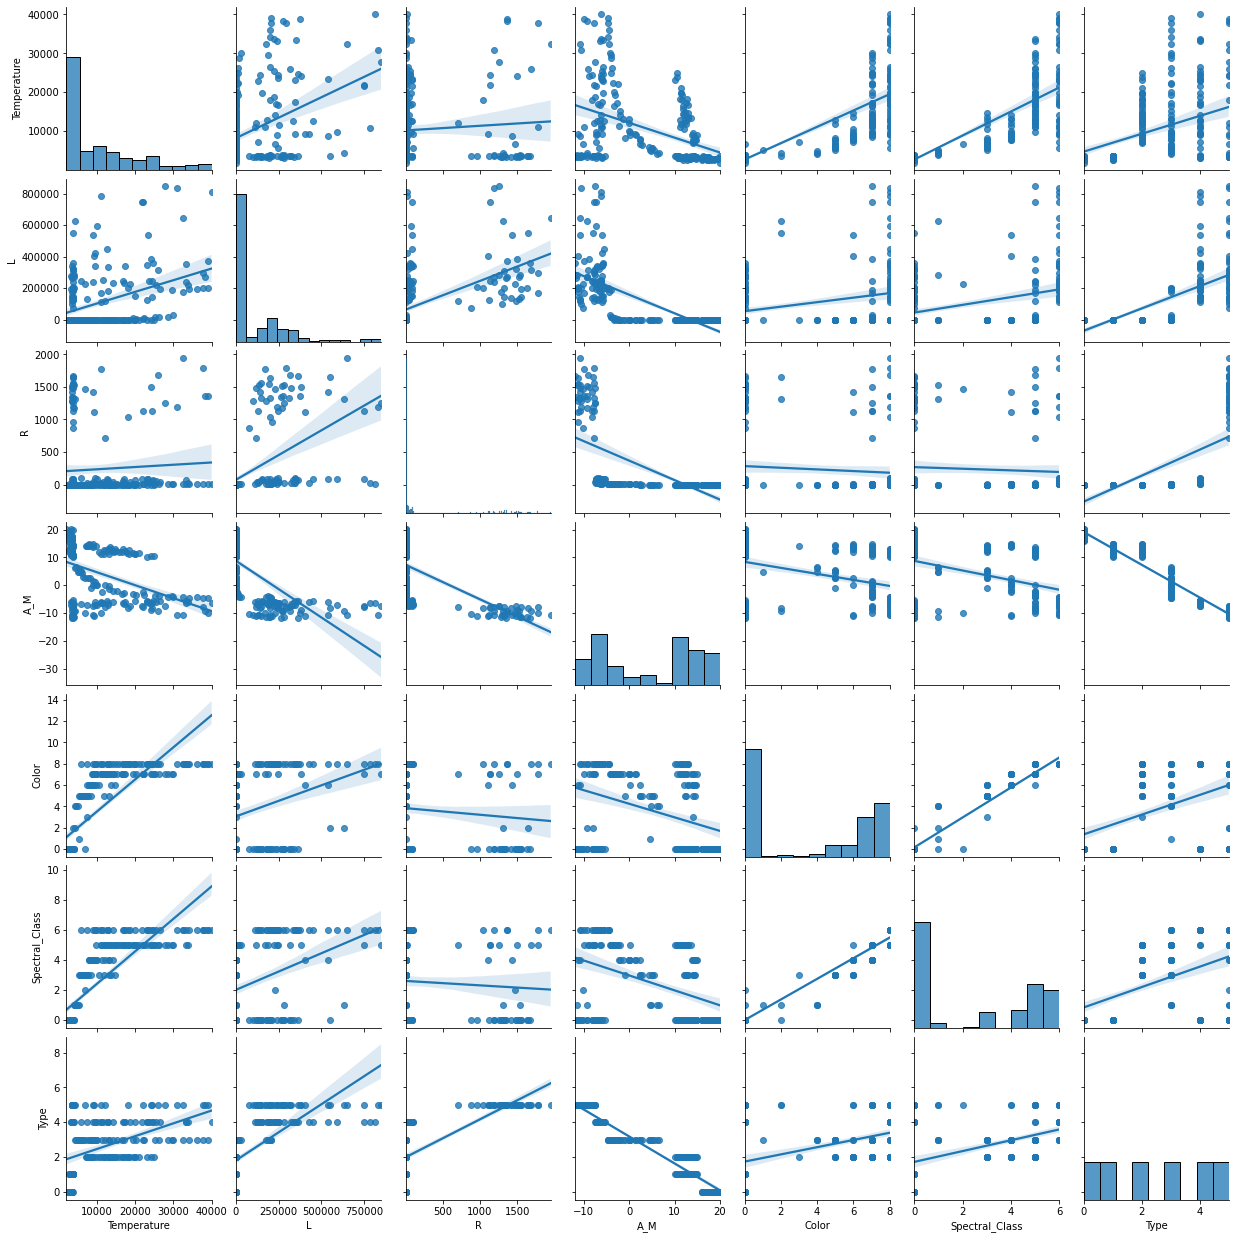

In [25]:
sns.pairplot(df, kind='reg', diag_kind='hist', palette='Rainbow')
plt.show()

Thanks to the pairplot visualisation we can observe previously identified correlations. The most important observations include:

- Very heavy negative correlation between Type and A_M

- Positive correlation between Type and L

- Positive correlation between Type and R

- Very heavy positive correlation between Color and Spectral_Class

- Heavy positive correlation between Spectral_Class and temperature

- Heavy positive correlation between Color and temperature

Heavy correlations between the target variable and features of the data (The first 3 above) are very desirable, while heavy correlations between different features (The last 3) are not, because they may end up not providing any meaningful data.

## Final feature engineering

### Remove non-encoded versions of categorical variables

In [27]:
df = df.drop(["Color_name", "Spectral_Class_name"], axis=1)
df.head()

,Temperature,L,R,A_M,Color,Spectral_Class,Type
0,3068,0.002400,0.1700,16.12,0,0,0
1,3042,0.000500,0.1542,16.60,0,0,0
2,2600,0.000300,0.1020,18.70,0,0,0
3,2800,0.000200,0.1600,16.65,0,0,0
4,1939,0.000138,0.1030,20.06,0,0,0


### Separate target and features

In [28]:
y = df["Type"]
y.head()

0    0
1    0
2    0
3    0
4    0
Name: Type, dtype: int64

In [30]:
X = df.drop(["Type"], axis=1)
X.head()

,Temperature,L,R,A_M,Color,Spectral_Class
0,3068,0.002400,0.1700,16.12,0,0
1,3042,0.000500,0.1542,16.60,0,0
2,2600,0.000300,0.1020,18.70,0,0
3,2800,0.000200,0.1600,16.65,0,0
4,1939,0.000138,0.1030,20.06,0,0


### Split features into train and test sets 

In [75]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=1)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(144, 6) (96, 6) (144,) (96,)


## Model training

### Train a default RandomForestClassifier

In [76]:
rfc_model = RandomForestClassifier(random_state=1)

rfc_model.fit(X_train, y_train)

y_pred_1 = rfc_model.predict(X_test)

score_1 = accuracy_score(y_test, y_pred_1)

print("Accuracy of default RandomForestClassifier = "+str(score_1))

Accuracy of default RandomForestClassifier = 1.0


Using just the default RandomForestClassifier model we're able to achieve perfect accuracy. This is most likely caused by following:

- High correlation values of all features with the target variable

- Relatively large ratio of observations to possible target classes 

- TODO

It is very important to note, however that our trained model is not perfect and will not always have perfect accuracy on new data, because:

- The amount of training observations was quite low (only 144)

- Several categorical feature values only appeared a few times (Such as Colors: Orange-Red, Yellow-Orange)

This flaw can be easily observed by changing the random_state variable of our train_test_split:

In [77]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=47)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(144, 6) (96, 6) (144,) (96,)


In [78]:
rfc_model = RandomForestClassifier(random_state=1)

rfc_model.fit(X_train, y_train)

y_pred_2 = rfc_model.predict(X_test)

score_2 = accuracy_score(y_test, y_pred_2)

print("Accuracy of default RandomForestClassifier with random_state of train_test_split changed = "+str(score_2))

Accuracy of default RandomForestClassifier with random_state of train_test_split changed = 0.9895833333333334


But even though it's not perfect, this model has an accuracy that's more than satisfying

### Examine feature importance

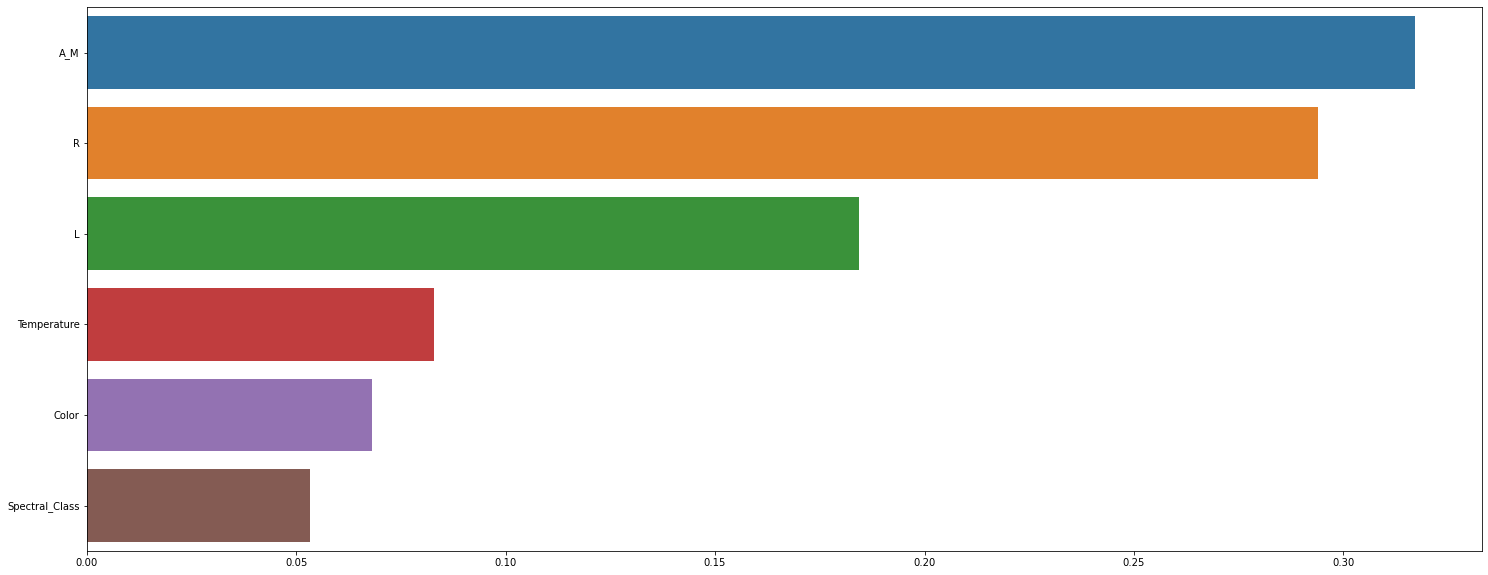

In [81]:
feature_importance = pd.Series(
    rfc_model.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(25, 10))
sns.barplot(x=feature_importance, y=feature_importance.index)
plt.show()

As we can see, features A_M and R together contribute to over 60% of the mean decrease in impurity